In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"usaidtirmizi","key":"719f6504a260da9b4bccc0b266ac4e1c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download kushagratandon12/diabetic-retinopathy-balanced


Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced
License(s): CC0-1.0
User cancelled operation


In [5]:
!ls
!unzip diabetic-retinopathy-balanced.zip
!ls
!mkdir -p dataset
!mv content/Diabetic_Balanced_Data/* dataset/
!rm -rf content
!rm -rf diabetic-retinopathy-balanced.zip
!ls dataset

Streaming output truncated to the last 5000 lines.
  inflating: content/Diabetic_Balanced_Data/val/2/30496_left._aug_21.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30496_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30509_right._aug_24.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30509_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30567_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30597_left._aug_28.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30597_left.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/3059_left.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/3070_right._aug_3.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30717_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/3074_left.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30782_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30787_left.jpeg  
  inflating: content/Diabetic_

In [7]:
from google.colab import drive

drive.mount('/content/drive')

!cp /content/drive/My\ Drive/hybrid_model_best.keras .

!ls

Mounted at /content/drive
dataset  drive	hybrid_model_best.keras  kaggle.json  sample_data


In [14]:
!pip install transformers tf-keras-vis tensorflow keras opencv-python albumentations matplotlib numpy scipy pandas sympy jupyter notebook pyzmq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.saving import register_keras_serializable

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

import numpy as np
import os

# Custom ViT Feature Extractor as a TensorFlow Layer

@register_keras_serializable()
class ViTFeatureExtractorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Define patch size and embedding dimension
        self.patch_size = 16
        self.hidden_size = 768
        self.num_patches = (224 // self.patch_size) ** 2

        # Learnable patch embedding layer
        self.patch_embedding = tf.keras.layers.Conv2D(
            filters=self.hidden_size,
            kernel_size=self.patch_size,
            strides=self.patch_size,
            padding='valid',
            name='patch_embedding'
        )

        # Class token and position embeddings
        self.cls_token = self.add_weight(
            shape=(1, 1, self.hidden_size),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
            name='cls_token'
        )

        self.position_embedding = self.add_weight(
            shape=(1, self.num_patches + 1, self.hidden_size),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
            name='position_embedding'
        )

        # Transformer blocks
        self.transformer_blocks = [
            TransformerBlock(self.hidden_size, num_heads=12, mlp_dim=3072)
            for _ in range(6)  # Using 6 layers instead of 12 to reduce complexity
        ]

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Normalize inputs to [-1, 1]
        x = tf.cast(inputs, tf.float32) / 127.5 - 1

        # Create patches
        patches = self.patch_embedding(x)
        batch_size = tf.shape(patches)[0]

        # Reshape to sequence format
        patches = tf.reshape(patches, [batch_size, -1, self.hidden_size])

        # Add class token
        cls_tokens = tf.repeat(self.cls_token, batch_size, axis=0)
        patches = tf.concat([cls_tokens, patches], axis=1)

        # Add position embeddings
        patches = patches + self.position_embedding

        # Pass through transformer blocks
        for transformer_block in self.transformer_blocks:
            patches = transformer_block(patches)

        # Apply layer norm
        patches = self.layer_norm(patches)

        # Return only the class token output
        return patches[:, 0]

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=dropout_rate
        )
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation=tf.nn.gelu),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(dropout_rate),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Self-attention with residual connection
        attention_output = self.attention(inputs, inputs)
        x = self.layernorm1(inputs + attention_output)

        # MLP with residual connection
        mlp_output = self.mlp(x)
        return self.layernorm2(x + mlp_output)


def create_dataset(directory, target_size=(224, 224), batch_size=32, training=False):
    """
    Create a tf.data.Dataset from image directory that provides both CNN and ViT inputs
    """
    # Get class names (subdirectories)
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    class_indices = {name: i for i, name in enumerate(class_names)}
    num_classes = len(class_names)

    # List all image files
    image_files = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(class_dir, filename))
                labels.append(class_indices[class_name])

    # Create dataset from file paths
    def process_path(file_path, label):
        # Read and decode image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)

        # Create CNN input - ResNet50 preprocessing
        cnn_img = tf.cast(img, tf.float32)
        # Replicate ResNet preprocessing
        cnn_img = cnn_img[..., ::-1]  # RGB to BGR
        cnn_img = tf.keras.applications.resnet50.preprocess_input(cnn_img)

        # Create ViT input - Simple scaling to [0,1]
        vit_img = tf.cast(img, tf.float32) / 255.0

        # One-hot encode the label
        label_one_hot = tf.one_hot(label, depth=num_classes)

        return (cnn_img, vit_img), label_one_hot

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))

    # Shuffle the dataset if training
    if training:
        dataset = dataset.shuffle(buffer_size=len(image_files), reshuffle_each_iteration=True)

    # Process the images and batch the dataset
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Return dataset and metadata
    return dataset, len(image_files), num_classes, class_indices

def create_train_val_test_datasets(train_dir, val_dir, test_dir, batch_size):

    train_dataset, _, num_classes, class_indices = create_dataset(
        train_dir, batch_size=batch_size, training=True
    )
    val_dataset, _, _, _ = create_dataset(
        val_dir, batch_size=batch_size, training=False
    )
    test_dataset, _, _, _ = create_dataset(
        test_dir, batch_size=batch_size, training=False
    )
    return train_dataset, val_dataset, test_dataset, num_classes, class_indices


def build_hybrid_model(input_shape=(224, 224, 3), num_classes=5):
    # Dual input layers
    resnet_input = Input(shape=input_shape, name='resnet_input')
    vit_input = Input(shape=input_shape, name='vit_input')

    # ResNet50 branch
    cnn_base = ResNet50(weights='imagenet', include_top=False, input_tensor=resnet_input)
    # Freeze some early layers of ResNet
    for layer in cnn_base.layers[:100]:
        layer.trainable = False

    cnn_features = GlobalAveragePooling2D()(cnn_base.output)
    cnn_features = Dense(512, activation='relu')(cnn_features)
    cnn_features = Dropout(0.3)(cnn_features)

    # ViT branch with our custom implementation
    vit_layer = ViTFeatureExtractorLayer()
    vit_features = vit_layer(vit_input)
    vit_features = Dense(512, activation='relu')(vit_features)
    vit_features = Dropout(0.3)(vit_features)

    # Combined model
    combined = Concatenate()([cnn_features, vit_features])
    combined = Dense(512, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[resnet_input, vit_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_dir='dataset/train', val_dir='dataset/val', epochs=15, batch_size=32):

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'hybrid_model_best.keras',
            save_best_only=True,
            monitor='val_accuracy'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

    # Train model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Evaluate model
    evaluation = model.evaluate(test_dataset)

    print(f"Test loss: {evaluation[0]}")
    print(f"Test accuracy: {evaluation[1]}")

    # Save final model
    model.save('hybrid_model_final.keras')

    return model, history

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

def evaluate_model(model, test_dataset, class_names):
    """
    Enhanced evaluation with comprehensive metrics and visualizations
    """
    # Get true labels and predictions
    y_true = []
    y_pred = []
    all_probs = []

    # Process batches
    for batch in test_dataset:
        inputs, labels = batch
        # Ensure input is properly formatted for the model
        if isinstance(inputs, tuple):
            # Already in the right format (resnet_input, vit_input)
            predictions = model.predict(inputs, verbose=0)
        else:
            # Need to split the input for both branches
            predictions = model.predict([inputs, inputs], verbose=0)

        # Extract labels and predictions
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
        all_probs.extend(predictions)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    all_probs = np.array(all_probs)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Class performance visualization
    class_accuracy = np.zeros(len(class_names))
    for i in range(len(class_names)):
        idx = (y_true == i)
        if np.sum(idx) > 0:  # Avoid division by zero
            class_accuracy[i] = np.sum(y_pred[idx] == i) / np.sum(idx)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_accuracy)
    plt.title('Accuracy by Class')
    plt.ylabel('Accuracy')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate ROC curves for multiclass (one-vs-rest)
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize

    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, all_probs

def explain_model(model, test_dataset, class_names, num_samples=5):
    """
    Custom Grad-CAM implementation for hybrid models that manually computes
    the gradients rather than relying on tf_keras_vis
    """
    import numpy as np
    import tensorflow as tf
    import cv2
    import matplotlib.pyplot as plt

    # Find the last convolutional layer in ResNet branch
    last_conv_layer_name = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):  # Handle nested models (like ResNet)
            for nested_layer in layer.layers:
                if 'conv5_block3_out' in nested_layer.name:
                    last_conv_layer_name = nested_layer.name
                    break
        elif 'conv5_block3_out' in layer.name:
            last_conv_layer_name = layer.name
            break

    if last_conv_layer_name is None:
        # Fallback to any convolutional layer
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                print(f"Using layer: {last_conv_layer_name}")
                break

    # Get sample inputs and corresponding labels
    for batch in test_dataset:
        sample_images, sample_labels = batch
        if isinstance(sample_images, tuple):
            resnet_inputs, vit_inputs = sample_images
        else:
            resnet_inputs = vit_inputs = sample_images

        resnet_inputs = resnet_inputs[:num_samples]
        vit_inputs = vit_inputs[:num_samples]
        sample_labels = sample_labels[:num_samples]
        break

# Function to generate Grad-CAM for a single image
def generate_gradcam(img_array, target_class_idx):
    # Create a model that outputs both the last conv layer outputs and the final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs[0], model.inputs[1]],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Cast inputs to float32
    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        # Add a batch dimension and process the image
        resnet_input = tf.expand_dims(img_array[0], axis=0)
        vit_input = tf.expand_dims(img_array[1], axis=0)

        # Get model predictions and feature maps
        conv_outputs, predictions = grad_model([resnet_input, vit_input])
        target_class_output = predictions[:, target_class_idx]

    # Gradient of the target class with respect to the conv layer output
    grads = tape.gradient(target_class_output, conv_outputs)

    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by the incoming gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

    # Apply ReLU to focus on features that have a positive influence on the target class
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()

    # Make predictions and generate heatmaps
    predictions = model.predict([resnet_inputs, vit_inputs], verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(sample_labels.numpy(), axis=1)

    # Generate heatmaps for each sample
    heatmaps = []
    for i in range(num_samples):
        # Use the predicted class as target
        target_class = pred_classes[i]

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam([resnet_inputs[i], vit_inputs[i]], target_class)
        heatmaps.append(heatmap)

    # Visualization
    plt.figure(figsize=(20, 4 * num_samples))
    for i in range(num_samples):
        # Process original image
        img = resnet_inputs[i].numpy()
        # Convert BGR to RGB if using ResNet preprocessing
        img = img[..., ::-1]  # BGR to RGB
        # Normalize to [0,1] for visualization
        img = (img - img.min()) / (img.max() - img.min())

        # Process heatmap
        heatmap = heatmaps[i]
        # Resize heatmap to match input image size
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        # Convert to uint8 and colormap
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        superimposed = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap, 0.4, 0)

        # Create subplots
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_classes[i]]}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nConfidence: {predictions[i][pred_classes[i]]*100:.1f}%")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return heatmaps

def analyze_model(model, test_dataset, class_names):
    """
    Comprehensive model performance analysis
    """
    # First run basic evaluation
    y_true, y_pred, all_probs = evaluate_model(model, test_dataset, class_names)

    # Analyze per-class performance in detail
    class_analysis = []
    for i, class_name in enumerate(class_names):
        # Get indices for this class
        class_indices = (y_true == i)
        if not any(class_indices):
            continue

        # Calculate metrics
        correct_count = np.sum(y_pred[class_indices] == i)
        total_count = np.sum(class_indices)
        accuracy = correct_count / total_count

        # Find common misclassifications
        if total_count - correct_count > 0:
            misclassified = y_pred[class_indices & (y_pred != i)]
            most_common_error = np.bincount(misclassified).argmax() if len(misclassified) > 0 else None
            error_count = np.sum(misclassified == most_common_error) if most_common_error is not None else 0
            error_pct = error_count / total_count if total_count > 0 else 0
            most_common_error_class = class_names[most_common_error] if most_common_error is not None else "None"
        else:
            most_common_error_class = "None"
            error_pct = 0

        # Calculate confidence statistics for correct predictions
        correct_indices = class_indices & (y_pred == i)
        if any(correct_indices):
            correct_confidences = np.max(all_probs[correct_indices], axis=1)
            avg_confidence = np.mean(correct_confidences)
            min_confidence = np.min(correct_confidences)
            max_confidence = np.max(correct_confidences)
        else:
            avg_confidence = min_confidence = max_confidence = 0

        # Store analysis
        class_analysis.append({
            'class': class_name,
            'accuracy': accuracy,
            'sample_count': total_count,
            'most_common_error': most_common_error_class,
            'error_percentage': error_pct,
            'avg_confidence': avg_confidence,
            'min_confidence': min_confidence,
            'max_confidence': max_confidence
        })

    # Print the analysis as a table
    print("\nDetailed Class Performance Analysis:")
    print("-" * 100)
    print(f"{'Class':<15} | {'Accuracy':<10} | {'Samples':<8} | {'Most Common Error':<20} | {'Error %':<8} | {'Avg Conf':<8} | {'Min Conf':<8} | {'Max Conf':<8}")
    print("-" * 100)

    for analysis in class_analysis:
        print(f"{analysis['class']:<15} | {analysis['accuracy']:.2f}      | {analysis['sample_count']:<8} | "
              f"{analysis['most_common_error']:<20} | {analysis['error_percentage']:.2f}    | "
              f"{analysis['avg_confidence']:.2f}    | {analysis['min_confidence']:.2f}    | {analysis['max_confidence']:.2f}")

    # Visualize confidence distributions
    plt.figure(figsize=(12, 6))

    # Plot confidence distributions for correct vs incorrect predictions
    correct_confidences = np.max(all_probs[y_pred == y_true], axis=1)
    incorrect_confidences = np.max(all_probs[y_pred != y_true], axis=1)

    plt.hist(correct_confidences, alpha=0.7, label='Correct Predictions', bins=20, range=(0, 1))
    if len(incorrect_confidences) > 0:
        plt.hist(incorrect_confidences, alpha=0.7, label='Incorrect Predictions', bins=20, range=(0, 1))

    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return class_analysis

def visualize_activations(model, test_dataset, layer_name='conv5_block3_out', num_samples=3, num_filters=16):
    """
    Visualize activations of specific layers for insights into what the model sees
    """
    # Find the requested layer
    target_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.InputLayer):
            continue
        if layer_name in layer.name:
            target_layer = layer
            break
        if hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if layer_name in sublayer.name:
                    target_layer = sublayer
                    break
            if target_layer is not None:
                break

    if target_layer is None:
        print(f"Layer {layer_name} not found. Available layers:")
        for layer in model.layers:
            if not isinstance(layer, tf.keras.layers.InputLayer):
                print(f"- {layer.name}")
        return

    # Create a model that outputs the target layer's activations
    activation_model = tf.keras.Model(
        inputs=model.input[0],  # Just use the ResNet input for simplicity
        outputs=target_layer.output
    )

    # Get sample images
    for inputs, _ in test_dataset:
        if isinstance(inputs, tuple):
            images = inputs[0]
        else:
            images = inputs
        images = images[:num_samples]
        break

    # Get activations
    activations = activation_model.predict(images)

    # Visualize the activations of a few filters
    for i in range(min(num_samples, len(images))):
        plt.figure(figsize=(15, 10))

        # Show the original image
        plt.subplot(num_filters//4 + 1, 4, 1)
        img = images[i].numpy()
        img = img[..., ::-1]  # BGR to RGB
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize to [0,1]
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Display activations for selected filters
        for j in range(min(num_filters, activations.shape[-1])):
            plt.subplot(num_filters//4 + 1, 4, j + 2)
            activation = activations[i, :, :, j]
            plt.imshow(activation, cmap='viridis')
            plt.title(f"Filter {j}")
            plt.axis('off')

        plt.tight_layout()
        plt.suptitle(f"Activations for sample {i+1} at layer '{layer_name}'", y=1.02)
        plt.show()


In [17]:
# Create datasets
train_dataset, val_dataset, test_dataset, num_classes, class_indices = create_train_val_test_datasets(
    "dataset/train", "dataset/val", "dataset/test", batch_size=32
)

In [ ]:
# Build model
model = build_hybrid_model(num_classes=num_classes)

In [ ]:
# Train model
model, history = train_model(model, train_dataset, val_dataset, num_classes, epochs=15)

In [18]:
# Load the trained model
model = tf.keras.models.load_model('hybrid_model_best.keras', custom_objects={'ViTFeatureExtractorLayer': ViTFeatureExtractorLayer})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vi_t_feature_extractor_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63      1000
           1       0.67      0.63      0.65       971
           2       0.62      0.57      0.59      1000
           3       0.93      0.92      0.92      1000
           4       0.96      0.97      0.96      1000

    accuracy                           0.75      4971
   macro avg       0.76      0.75      0.75      4971
weighted avg       0.76      0.75      0.75      4971



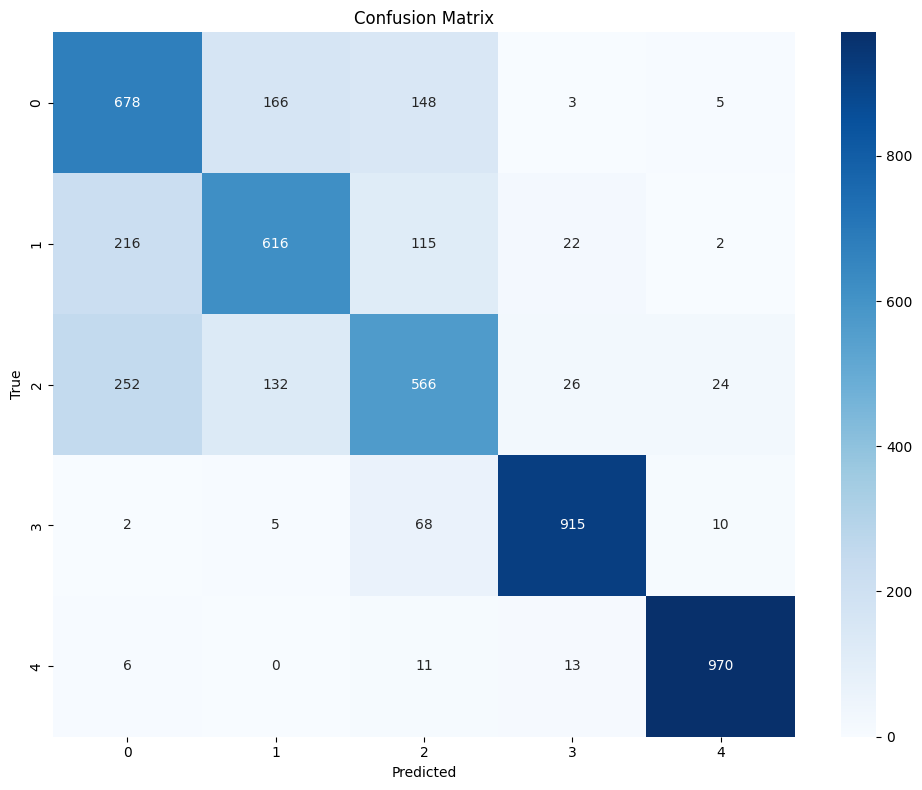

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

<Figure size 1000x600 with 0 Axes>

In [19]:
# Evaluate the model
y_true, y_pred, all_probs = evaluate_model(model, test_dataset, class_indices)

KeyError: np.int64(0)

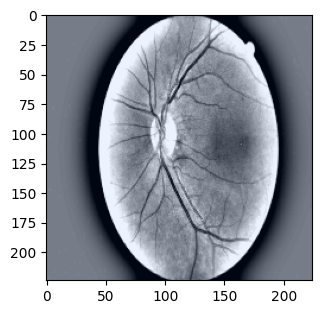

In [20]:
# Explain model predictions visually
heatmaps = explain_model(model, test_dataset, class_indices, num_samples=5)


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63      1000
           1       0.67      0.63      0.65       971
           2       0.62      0.57      0.59      1000
           3       0.93      0.92      0.92      1000
           4       0.96      0.97      0.96      1000

    accuracy                           0.75      4971
   macro avg       0.76      0.75      0.75      4971
weighted avg       0.76      0.75      0.75      4971



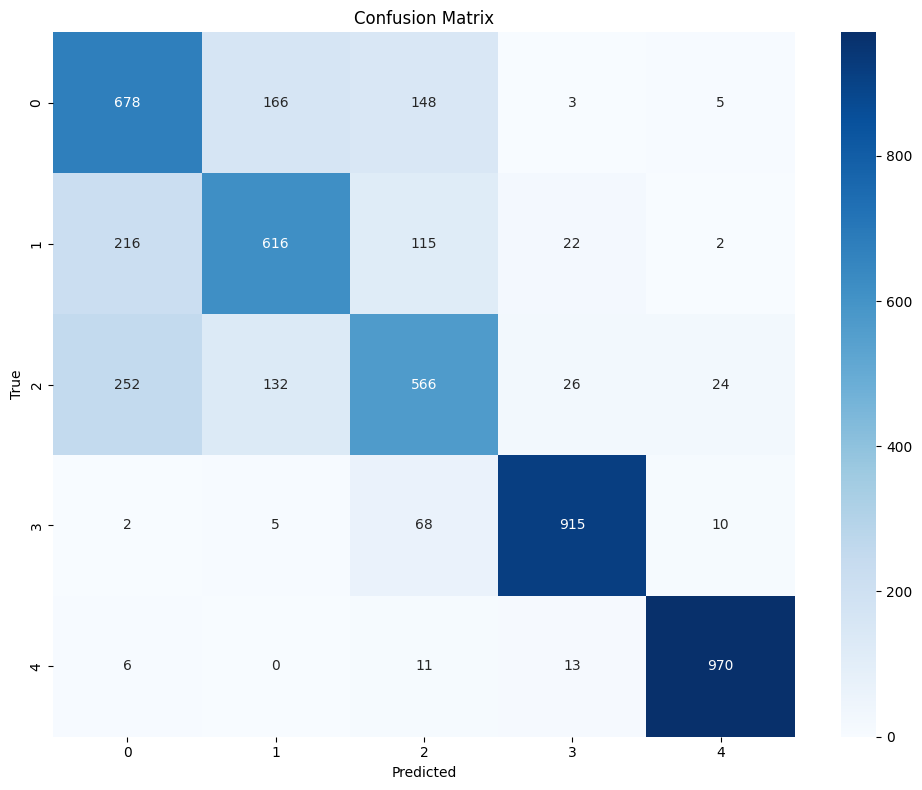

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

<Figure size 1000x600 with 0 Axes>

In [21]:
# Analyze model
analyze_model(model, test_dataset, class_indices)

# Visualize activations
visualize_activations(model, test_dataset, layer_name='conv5_block3_out', num_samples=3, num_filters=16)